<a href="https://colab.research.google.com/github/ArmFriiz/Dicoding-Submission-FDL/blob/main/Analisis%20Sentimen/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Preparation**
- Muhammad Faris Akbar
- Dicoding Analisis Sentimen (Fundamental Deep Learning)

**Load package dan library**

In [125]:
!pip install gensim

In [126]:
import re
import kagglehub
import gensim
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample, class_weight

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, concatenate, Input, LayerNormalization, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [127]:
path = kagglehub.dataset_download("bhimantoros/pretrained-word2vec-indonesia")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pretrained-word2vec-indonesia' dataset.
Path to dataset files: /kaggle/input/pretrained-word2vec-indonesia


In [128]:
fix_path = os.path.join(path, "wiki.id.case.model")
print("Path to model file:", fix_path)

Path to model file: /kaggle/input/pretrained-word2vec-indonesia/wiki.id.case.model


**Load dataset sentimen**

In [129]:
df = pd.read_csv('https://raw.githubusercontent.com/ArmFriiz/Dicoding-Submission-FDL/refs/heads/main/Analisis%20Sentimen/dataset_ulasan_playstore.csv')

In [130]:
df.head()

,content,score,soft_clean_content,sentiment_label,confidence_score
0,CEPAT AMAN TERPERCAYA,5,CEPAT AMAN TERPERCAYA,Positif,0.997051
1,top markotop,5,top markotop,Positif,0.993329
2,belanja online nomor 1 satu di Indonesia.,5,belanja online nomor 1 satu di Indonesia.,Positif,0.996747
3,GANGGU DOANG LU ORG LAGI MAIN JUGA,1,GANGGU DOANG LU ORG LAGI MAIN JUGA,Negatif,0.993607
4,jadi langganan belanja di shopee..,5,jadi langganan belanja di shopee..,Positif,0.991705


In [131]:
df.rename(columns={'sentiment_label': 'label'}, inplace=True)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73475 entries, 0 to 73474
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   content             73475 non-null  object 
 1   score               73475 non-null  int64  
 2   soft_clean_content  73475 non-null  object 
 3   label               73475 non-null  object 
 4   confidence_score    73475 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


In [133]:
df.describe(include='all')

,content,score,soft_clean_content,label,confidence_score
count,73475,73475.000000,73475,73475,73475.000000
unique,72702,NaN,72222,3,NaN
top,oke,NaN,baguss,Positif,NaN
freq,5,NaN,18,42847,NaN
mean,NaN,3.862851,NaN,NaN,0.961965
std,NaN,1.668424,NaN,NaN,0.096738
min,NaN,1.000000,NaN,NaN,0.350259
25%,NaN,2.000000,NaN,NaN,0.987019
50%,NaN,5.000000,NaN,NaN,0.997402
75%,NaN,5.000000,NaN,NaN,0.998817


**Load dataset tambahan**

In [134]:
# df_tambahan_netral = pd.read_csv('https://raw.githubusercontent.com/ArmFriiz/Dicoding-Submission-FDL/refs/heads/main/Analisis%20Sentimen/dataset_ulasan_playstore_netral.csv')

In [135]:
# df_tambahan_netral.info()

In [136]:
# df_tambahan_negatif = pd.read_csv('https://raw.githubusercontent.com/ArmFriiz/Dicoding-Submission-FDL/refs/heads/main/Analisis%20Sentimen/dataset_ulasan_playstore_negatif.csv')

In [137]:
# df_tambahan_negatif.info()

**Gabungkan dataset utama dan tambahan**

In [138]:
# df = pd.concat([main_df, df_tambahan_netral, df_tambahan_negatif]).reset_index(drop=True)

**Drop column score dam confidence score karena hanya digunakan untuk labelling awal saja**

In [139]:
df.drop(columns=['score', 'confidence_score'], inplace=True)

In [140]:
df.columns

Index(['content', 'soft_clean_content', 'label'], dtype='object')

**Cek ulang kondisi data**

In [141]:
df.isna().sum()

,0
content,0
soft_clean_content,0
label,0


In [142]:
df.duplicated().sum()

np.int64(773)

In [143]:
df.drop_duplicates(inplace=True)

In [144]:
df.duplicated().sum()

np.int64(0)

In [145]:
df.describe(include='all')

,content,soft_clean_content,label
count,72702,72702,72702
unique,72702,72222,3
top,bagus banget buat belanja secara daring dan be...,mantaapp,Positif
freq,1,13,42258


**Load model normalisasi kata untuk perbaikan kata slank atau typo**

In [146]:
normalization_df = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv')

In [147]:
normalization_df.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [148]:
normalization_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15006 entries, 0 to 15005
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   slang          15006 non-null  object
 1   formal         15006 non-null  object
 2   In-dictionary  15006 non-null  int64 
 3   context        15006 non-null  object
 4   category1      15006 non-null  object
 5   category2      15006 non-null  object
 6   category3      15006 non-null  object
dtypes: int64(1), object(6)
memory usage: 820.8+ KB


In [149]:
normalization_dict = dict(zip(normalization_df['slang'], normalization_df['formal']))

### **Preprocessing Data**

**Cleaning data (Case folding, Punctuation, Slankword atau typo)**

In [150]:
def cleaning_text(text, normalization_dict):
  text = text.lower() # Ubah teks menjadi huruf kecil

  words = text.split()
  words = [normalization_dict.get(word, word) for word in words]
  text = ' '.join(words)

  text = ''.join([char for char in text if char.isalpha() or char.isspace()])
  text = ' '.join(text.split()) # Bersihkan spasi berlebih di tengah dan di ujung
  return text

In [151]:
df['clean_content'] = df['soft_clean_content'].apply(cleaning_text, normalization_dict=normalization_dict)

In [152]:
df.head()

,content,soft_clean_content,label,clean_content
0,CEPAT AMAN TERPERCAYA,CEPAT AMAN TERPERCAYA,Positif,cepat aman terpercaya
1,top markotop,top markotop,Positif,top markotop
2,belanja online nomor 1 satu di Indonesia.,belanja online nomor 1 satu di Indonesia.,Positif,belanja online nomor satu di indonesia
3,GANGGU DOANG LU ORG LAGI MAIN JUGA,GANGGU DOANG LU ORG LAGI MAIN JUGA,Negatif,ganggu doang lu orang lagi main juga
4,jadi langganan belanja di shopee..,jadi langganan belanja di shopee..,Positif,jadi langganan belanja di shopee


**Cek jumlah label data dan kata yang terkandung pada data sebelum resample**

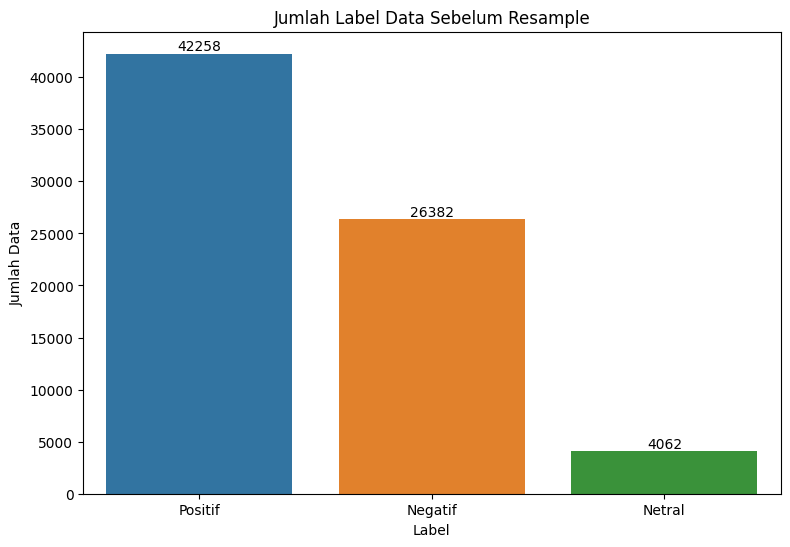

In [153]:
plt.figure(figsize=(9, 6))
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, hue=df['label'].value_counts().index)
plt.title('Jumlah Label Data Sebelum Resample')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.bar_label(plt.gca().containers[0])
plt.bar_label(plt.gca().containers[1])
plt.bar_label(plt.gca().containers[2])
plt.show()

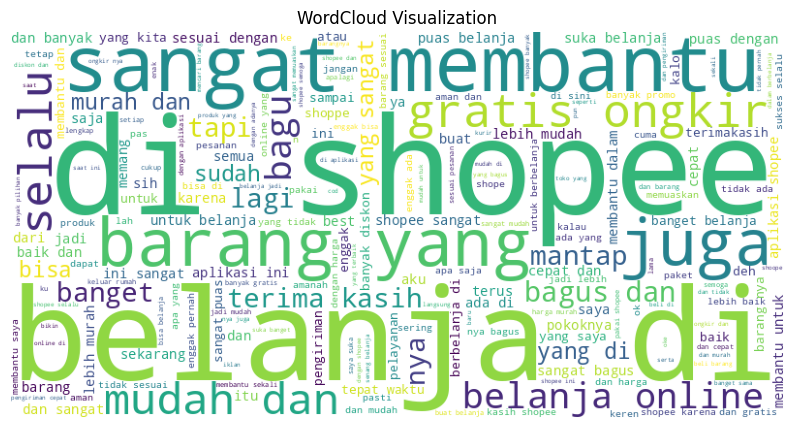

In [154]:
positif_content = df[df['label'] == 'Positif']['clean_content']

all_words = ''.join(positif_content)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

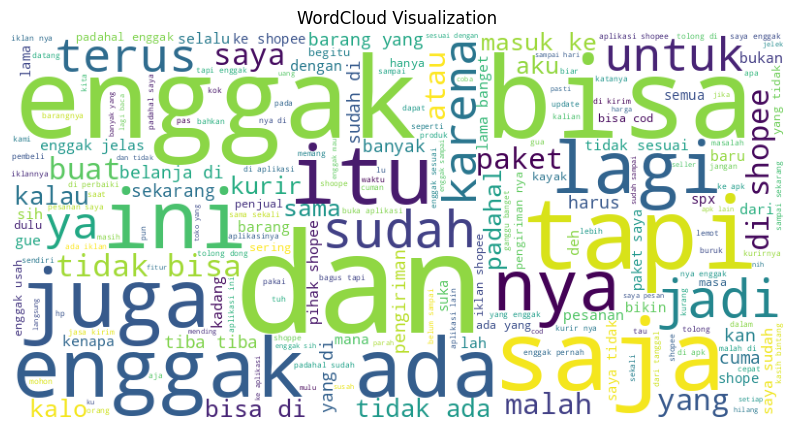

In [155]:
negatif_content = df[df['label'] == 'Negatif']['clean_content']

all_words = ''.join(negatif_content)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

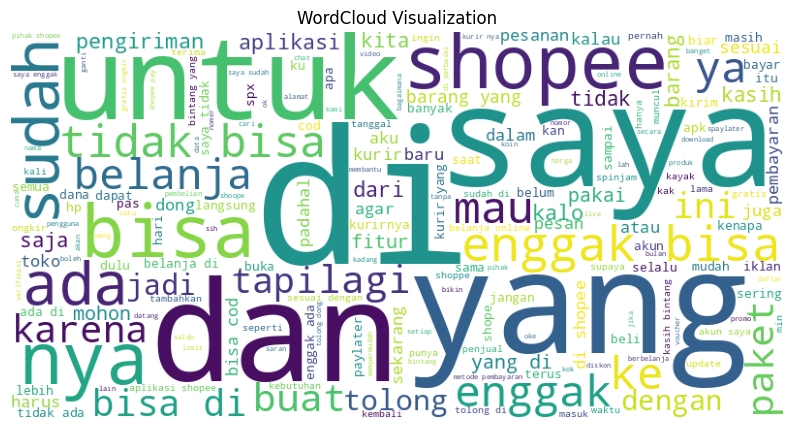

In [156]:
netral_content = df[df['label'] == 'Netral']['clean_content']

all_words = ''.join(netral_content)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

**Resample data berdasarkan class rata-rata**

In [157]:
df_negatif = df[df['label'] == 'Negatif']
df_netral = df[df['label'] == 'Netral']
df_positif = df[df['label'] == 'Positif']

n_samples = len(df_positif)

df_netral_upsampling = resample(df_netral, replace=True, n_samples=n_samples, random_state=42)
df_negatif_upsampling = resample(df_negatif, replace=True, n_samples=n_samples, random_state=42)

df_balanced = pd.concat([df_positif, df_negatif_upsampling, df_netral_upsampling])

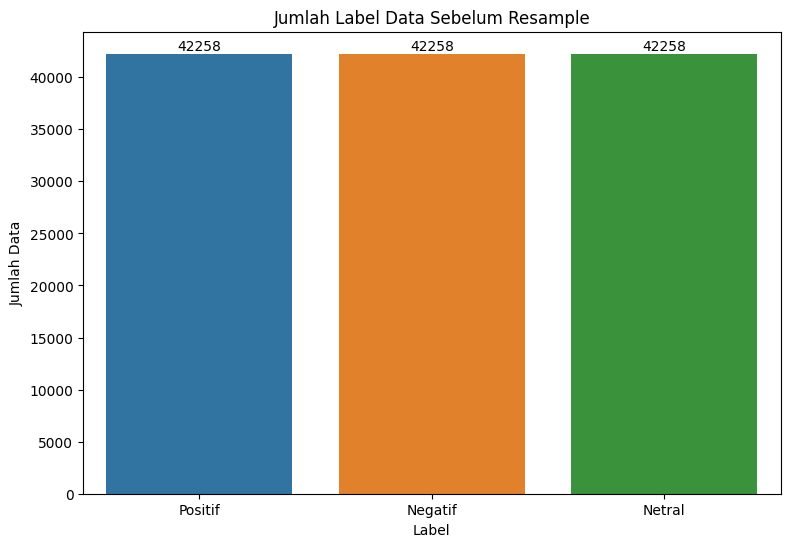

In [158]:
plt.figure(figsize=(9, 6))
sns.barplot(x=df_balanced['label'].value_counts().index, y=df_balanced['label'].value_counts().values, hue=df_balanced['label'].value_counts().index)
plt.title('Jumlah Label Data Sebelum Resample')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.bar_label(plt.gca().containers[0])
plt.bar_label(plt.gca().containers[1])
plt.bar_label(plt.gca().containers[2])
plt.show()

**Encoding label data**

In [159]:
le = LabelEncoder()
df_balanced['label_encoded'] = le.fit_transform(df_balanced['label'])

In [160]:
df_balanced.head()

,content,soft_clean_content,label,clean_content,label_encoded
0,CEPAT AMAN TERPERCAYA,CEPAT AMAN TERPERCAYA,Positif,cepat aman terpercaya,2
1,top markotop,top markotop,Positif,top markotop,2
2,belanja online nomor 1 satu di Indonesia.,belanja online nomor 1 satu di Indonesia.,Positif,belanja online nomor satu di indonesia,2
4,jadi langganan belanja di shopee..,jadi langganan belanja di shopee..,Positif,jadi langganan belanja di shopee,2
5,mantap,mantap,Positif,mantap,2


In [161]:
x = df_balanced['clean_content'].values

In [162]:
print(x)

['cepat aman terpercaya' 'top markotop'
 'belanja online nomor satu di indonesia' ...
 'enggak bagus bisa bisa nya saya enggak pesan paket tapi ada yang mesen paket pakai nama saya'
 'selalu ada promo'
 'tolong tambahkan tag premium di banner kategori biar memudahkan pelanggan memilah']


In [163]:
y = df_balanced['label_encoded'].values

In [164]:
print(y)
print(le.classes_)

[2 2 2 ... 1 1 1]
['Negatif' 'Netral' 'Positif']


In [165]:
y_onehot = to_categorical(y, num_classes=3)
y_onehot

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

**Splitting Data (Training-Testing-Validation) (80-20)**

In [166]:
X_train, X_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.20, random_state=42, stratify=y)

print(f"Jumlah Data Train : {len(X_train)}")
print(f"Jumlah Data Test  : {len(X_test)}")

Jumlah Data Train : 101419
Jumlah Data Test  : 25355


**Tokenization, sequence dan padding**

In [167]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

lens = [len(s) for s in X_train_seq]
# max_len = int(np.percentile(lens, 95))
max_len = max(lens)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='pre', truncating='pre')
X_test_pad = pad_sequences(X_test_seq,  maxlen=max_len, padding='pre', truncating='pre')

In [168]:
print("Ukuran Sequences : ", max_len)

Ukuran Sequences :  103


### **Model Word2Vec**

**Load model Word2Vec untuk transfer learning (input model)**

In [169]:
w2v_model = gensim.models.Word2Vec.load(fix_path).wv

In [170]:
EMBEDDING_DIM = 400

In [171]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

hits = 0
misses = 0

for word, i in word_index.items():
  if word in w2v_model:
    embedding_matrix[i] = w2v_model[word]
    hits += 1
  else:
    misses += 1

print(f"Berhasil: {hits}, Gagal (OOV): {misses}")

Berhasil: 10831, Gagal (OOV): 23610


**Balancing class menggunakan pembobotan**

In [172]:
# y_train_int = np.argmax(y_train, axis=1)

# class_weights_val = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_int),
#     y=y_train_int
# )
# class_weights_dict = dict(enumerate(class_weights_val))
# print(class_weights_dict)

### **Modelling**

In [173]:
akurasi_model = {}

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    accuracy = logs.get('accuracy')
    val_accuracy = logs.get('val_accuracy')

    if accuracy is not None and accuracy > 0.94 and val_accuracy > 0.94:
      print("\nAccuracy dan validation_accuracy > 94%. Menghentikan training.")
      self.model.stop_training = True

callback = myCallback()

**Model 1: BI-LSTM + Word Embedding**

In [174]:
inputs = Input(shape=(max_len,))

x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(x)
x = LayerNormalization()(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAvgPool1D()(x)

concatenated = concatenate([max_pool, avg_pool])

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

In [175]:
model_1 = keras.Model(inputs=inputs, outputs=outputs)

In [176]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_1 = model_1.fit(X_train_pad,
            y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_test_pad, y_test),
            verbose=1,
            callbacks=callback)

Epoch 1/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step - accuracy: 0.7701 - loss: 0.7812 - val_accuracy: 0.8969 - val_loss: 0.3077
Epoch 2/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.9186 - loss: 0.2596 - val_accuracy: 0.9197 - val_loss: 0.2424
Epoch 3/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9409 - loss: 0.1956 - val_accuracy: 0.9306 - val_loss: 0.2219
Epoch 4/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.9525 - loss: 0.1596 - val_accuracy: 0.9379 - val_loss: 0.2130
Epoch 5/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9587 - loss: 0.1365
Accuracy dan validation_accuracy > 94%. Menghentikan training.
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.9587 - loss: 0.1365 - val_accuracy: 0.9419 - val_loss: 0.2035


In [177]:
akurasi_model['BI-LSTM + Word Embedding'] = model_1.evaluate(X_test_pad, y_test)[1]

793/793 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9431 - loss: 0.2062


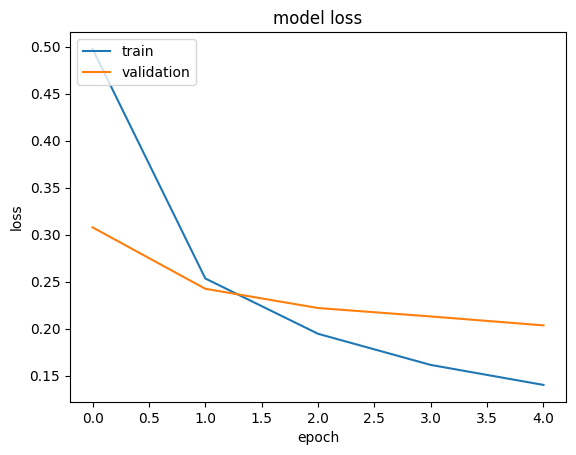

In [178]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [179]:
model_1.save('model_1.h5')

**Model 2: BI-LSTM + Word Embedding + Word2Vec Pre-Trained**

In [180]:
inputs = Input(shape=(max_len,))

x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(x)
x = LayerNormalization()(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAvgPool1D()(x)

concatenated = concatenate([max_pool, avg_pool])

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

In [181]:
model_2 = keras.Model(inputs=inputs, outputs=outputs)

In [182]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_2 = model_2.fit(X_train_pad,
            y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_test_pad, y_test),
            verbose=1,
            callbacks=callback)

Epoch 1/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.7333 - loss: 0.8171 - val_accuracy: 0.8244 - val_loss: 0.4736
Epoch 2/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.8191 - loss: 0.4999 - val_accuracy: 0.8473 - val_loss: 0.4260
Epoch 3/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.8380 - loss: 0.4571 - val_accuracy: 0.8536 - val_loss: 0.4122
Epoch 4/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.8487 - loss: 0.4254 - val_accuracy: 0.8644 - val_loss: 0.3818
Epoch 5/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8611 - loss: 0.3973 - val_accuracy: 0.8794 - val_loss: 0.3582
Epoch 6/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.8709 - loss: 0.3731 - val_accuracy: 0.8769 - val_loss: 0.3545
Epoch 7/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.8779 - loss: 0.3566 - val_accuracy: 0.8890 - val_loss: 0.3251
Epoch 8/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.8876 -

In [183]:
akurasi_model['BI-LSTM + Word Embedding + Word2Vec Pre-Trained'] = model_2.evaluate(X_test_pad, y_test)[1]

793/793 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9313 - loss: 0.2133


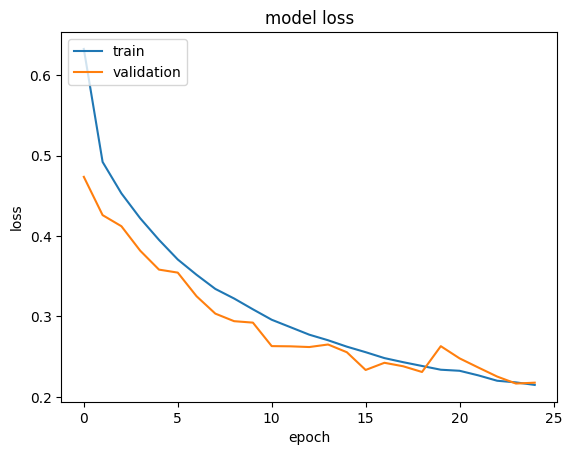

In [184]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [185]:
model_2.save('model_2.h5')

**Model 3: RNN + Word Embedding**

In [186]:
inputs = Input(shape=(max_len,))

x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = SpatialDropout1D(0.3)(x)
x = SimpleRNN(64, dropout=0.2, return_sequences=True)(x)
x = LayerNormalization()(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAvgPool1D()(x)

concatenated = concatenate([max_pool, avg_pool])

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

In [187]:
model_3 = keras.Model(inputs=inputs, outputs=outputs)

In [188]:
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_3 = model_3.fit(X_train_pad,
            y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_test_pad, y_test),
            verbose=1,
            callbacks=callback)

Epoch 1/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.7255 - loss: 0.8658 - val_accuracy: 0.8984 - val_loss: 0.3139
Epoch 2/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9087 - loss: 0.3005 - val_accuracy: 0.9109 - val_loss: 0.2756
Epoch 3/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9316 - loss: 0.2347 - val_accuracy: 0.9260 - val_loss: 0.2399
Epoch 4/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9414 - loss: 0.2001 - val_accuracy: 0.9353 - val_loss: 0.2289
Epoch 5/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9472 - loss: 0.1801 - val_accuracy: 0.9332 - val_loss: 0.2196
Epoch 6/25
3167/3170 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9509 - loss: 0.1655
Accuracy dan validation_accuracy > 94%. Menghentikan training.
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9509 - loss: 0.1655 - val_accuracy: 0.9412 - val_loss: 0.2106


In [189]:
akurasi_model['RNN + Word Embedding'] = model_3.evaluate(X_test_pad, y_test)[1]

793/793 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9403 - loss: 0.2126


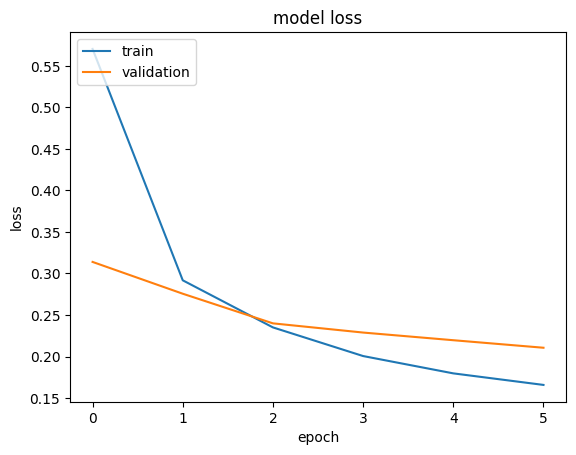

In [190]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [191]:
model_3.save('model_3.h5')

**Model 4: RNN + Word Embedding + Word2Vec Pre-Trained**

In [192]:
inputs = Input(shape=(max_len,))

x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
x = SpatialDropout1D(0.3)(x)
x = SimpleRNN(64, dropout=0.2, return_sequences=True)(x)
x = LayerNormalization()(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAvgPool1D()(x)

concatenated = concatenate([max_pool, avg_pool])

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

In [193]:
model_4 = keras.Model(inputs=inputs, outputs=outputs)

In [194]:
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_4 = model_4.fit(X_train_pad,
            y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_test_pad, y_test),
            verbose=1,
            callbacks=callback)

Epoch 1/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.6857 - loss: 1.0095 - val_accuracy: 0.8218 - val_loss: 0.5014
Epoch 2/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.7939 - loss: 0.5537 - val_accuracy: 0.8279 - val_loss: 0.4725
Epoch 3/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.8137 - loss: 0.5087 - val_accuracy: 0.8435 - val_loss: 0.4294
Epoch 4/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.8200 - loss: 0.4860 - val_accuracy: 0.8484 - val_loss: 0.4153
Epoch 5/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.8274 - loss: 0.4720 - val_accuracy: 0.8505 - val_loss: 0.4198
Epoch 6/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.8341 - loss: 0.4554 - val_accuracy: 0.8617 - val_loss: 0.3928
Epoch 7/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.8371 - loss: 0.4513 - val_accuracy: 0.8587 - val_loss: 0.3931
Epoch 8/25
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.8370 -

In [195]:
akurasi_model['RNN + Word Embedding + Word2Vec Pre-Trained'] = model_4.evaluate(X_test_pad, y_test)[1]

793/793 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8829 - loss: 0.3455


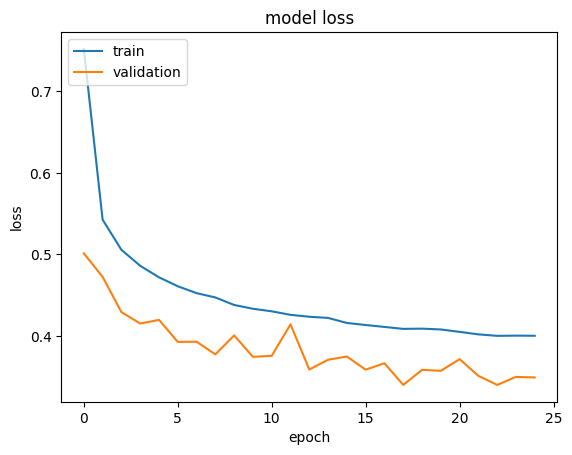

In [196]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [197]:
model_4.save('model_4.h5')

**Model 5: Logistic Regression + Word2Vec Pre-Trained (Average Weight)**

In [198]:
def get_avg_vector(text_list, model, dim):
  vecs = []
  for text in text_list:
    words = text.split()
    vector_sum = np.zeros((dim,), dtype="float32")
    n_words = 0

    for w in words:
      if w in model:
        vector_sum = np.add(vector_sum, model[w])
        n_words += 1

    if n_words > 0:
      vector_sum = np.divide(vector_sum, n_words)

    vecs.append(vector_sum)
  return np.array(vecs)

In [199]:
X_train_w2v = get_avg_vector(X_train, w2v_model, EMBEDDING_DIM)
X_test_w2v = get_avg_vector(X_test, w2v_model, EMBEDDING_DIM)
y_label_init = np.argmax(y_train, axis=1)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_w2v, y_label_init)

LogisticRegression(max_iter=1000)

In [200]:
y_pred_3 = clf.predict(X_test_w2v)
acc = accuracy_score(np.argmax(y_test, axis=1), y_pred_3)

print(f"Akurasi: {acc*100:.2f}%")
print(classification_report(np.argmax(y_test, axis=1), y_pred_3))

Akurasi: 77.77%
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      8451
           1       0.75      0.73      0.74      8452
           2       0.82      0.82      0.82      8452

    accuracy                           0.78     25355
   macro avg       0.78      0.78      0.78     25355
weighted avg       0.78      0.78      0.78     25355



In [201]:
akurasi_model['Logistic Regression + Word2Vec Pre-Trained (Average Weight)'] = acc

In [202]:
with open('model_5.pkl', 'wb') as f:
  pickle.dump(clf, f)

### **Akumulasi Akurasi Model**

In [203]:
count = 1
for key, value in akurasi_model.items():
  print(f"{count}. {key}: {value*100:.2f}%")
  count+=1

1. BI-LSTM + Word Embedding: 94.19%
2. BI-LSTM + Word Embedding + Word2Vec Pre-Trained: 93.09%
3. RNN + Word Embedding: 94.12%
4. RNN + Word Embedding + Word2Vec Pre-Trained: 87.95%
5. Logistic Regression + Word2Vec Pre-Trained (Average Weight): 77.77%


### **Test Prediksi Model**

In [204]:
teks = "barang nya hancur banget, nyesel beli disini!!!"

In [205]:
text_cleaned = cleaning_text(teks, normalization_dict)

text_seq = tokenizer.texts_to_sequences([text_cleaned])

text_padded = pad_sequences(text_seq, maxlen=max_len, padding='pre', truncating='pre')

In [206]:
teks_2 = "barang nya bagus, pengiriman cepat"

In [207]:
text_cleaned_2 = cleaning_text(teks_2, normalization_dict)

text_seq_2 = tokenizer.texts_to_sequences([text_cleaned_2])

text_padded_2 = pad_sequences(text_seq_2, maxlen=max_len, padding='pre', truncating='pre')

**Model 1**

In [208]:
prediction_prob = model_1.predict(text_padded)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Teks: barang nya hancur banget, nyesel beli disini!!!
Label prediksi: Negatif
Confidence: 73.53%


In [209]:
prediction_prob = model_1.predict(text_padded_2)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks_2}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Teks: barang nya bagus, pengiriman cepat
Label prediksi: Positif
Confidence: 99.98%


**Model 2**

In [210]:
prediction_prob = model_2.predict(text_padded)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Teks: barang nya hancur banget, nyesel beli disini!!!
Label prediksi: Negatif
Confidence: 99.34%


In [211]:
prediction_prob = model_2.predict(text_padded_2)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks_2}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Teks: barang nya bagus, pengiriman cepat
Label prediksi: Positif
Confidence: 99.41%


**Model 3**

In [212]:
prediction_prob = model_3.predict(text_padded)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Teks: barang nya hancur banget, nyesel beli disini!!!
Label prediksi: Negatif
Confidence: 99.42%


In [213]:
prediction_prob = model_3.predict(text_padded_2)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks_2}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Teks: barang nya bagus, pengiriman cepat
Label prediksi: Positif
Confidence: 99.69%


**Model 4**

In [214]:
prediction_prob = model_4.predict(text_padded)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Teks: barang nya hancur banget, nyesel beli disini!!!
Label prediksi: Negatif
Confidence: 97.32%


In [215]:
prediction_prob = model_4.predict(text_padded_2)
prediction_index = np.argmax(prediction_prob)
confidence = np.max(prediction_prob) * 100
final_label = le.inverse_transform([prediction_index])[0]

print(f"Teks: {teks_2}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Teks: barang nya bagus, pengiriman cepat
Label prediksi: Positif
Confidence: 99.80%


**Model 5**

In [216]:
text_w2v = get_avg_vector([text_cleaned], w2v_model, EMBEDDING_DIM)
prediction_index_3 = clf.predict(text_w2v)[0]
final_label_3 = le.inverse_transform([prediction_index_3])[0]

print(f"Teks: {teks}")
print(f"Label prediksi: {final_label_3}")

Teks: barang nya hancur banget, nyesel beli disini!!!
Label prediksi: Negatif


In [217]:
text_w2v = get_avg_vector([text_cleaned_2], w2v_model, EMBEDDING_DIM)
prediction_index_3 = clf.predict(text_w2v)[0]
final_label_3 = le.inverse_transform([prediction_index_3])[0]

print(f"Teks: {teks_2}")
print(f"Label prediksi: {final_label_3}")

Teks: barang nya bagus, pengiriman cepat
Label prediksi: Positif


**Load requirements.txt**

In [ ]:
# !pip freeze > requirements.txt